In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import ast
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

### **Analizando la tabla user_items**

In [2]:
items=pd.read_parquet("datasets/users_items.parquet")
items

,item_id,item_name,playtime_forever,playtime_2weeks,user_id,items_count,steam_id,user_url
0,10,Counter-Strike,6.0,0.0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
1,20,Team Fortress Classic,0.0,0.0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
2,30,Day of Defeat,7.0,0.0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
3,40,Deathmatch Classic,0.0,0.0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
4,50,Half-Life: Opposing Force,0.0,0.0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...
...,...,...,...,...,...,...,...,...
5153204,346330,BrainBread 2,0.0,0.0,76561198329548331,7,76561198329548331,http://steamcommunity.com/profiles/76561198329...
5153205,373330,All Is Dust,0.0,0.0,76561198329548331,7,76561198329548331,http://steamcommunity.com/profiles/76561198329...
5153206,388490,One Way To Die: Steam Edition,3.0,3.0,76561198329548331,7,76561198329548331,http://steamcommunity.com/profiles/76561198329...
5153207,521570,You Have 10 Seconds 2,4.0,4.0,76561198329548331,7,76561198329548331,http://steamcommunity.com/profiles/76561198329...


la tabla consiste en la informacion de cada usario, tiene informacion de su id del link de su perfil y de la informaciond e todos los juegos que ha jugado en una tabla anidada.

vamos a eliminar los duplicados ya que no los necesitamos y podrian afectar posible analisis mas adelante

In [3]:
items.drop(items[items.duplicated()].index,inplace=True)

In [4]:
items.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5094105 entries, 0 to 5153208
Data columns (total 8 columns):
 #   Column            Dtype  
---  ------            -----  
 0   item_id           object 
 1   item_name         object 
 2   playtime_forever  float64
 3   playtime_2weeks   float64
 4   user_id           object 
 5   items_count       int64  
 6   steam_id          object 
 7   user_url          object 
dtypes: float64(2), int64(1), object(5)
memory usage: 349.8+ MB


 se crea una tabla con la cantidad de items de cada usuario y la cantidad de items que viene en la tabla "items_count"

In [5]:
tab=items[["user_id","item_id","items_count"]].groupby(["user_id","items_count"]).agg({"item_id":"count"}).reset_index()

solo 16 jugadores tenian el campo items_count incorrecto, por eso podemos borrar ese campo ya que no termina ser preciso

In [6]:
#hay la cantidad de registros 
mask=tab["item_id"]!=tab["items_count"]
tab[mask]

,user_id,items_count,item_id
13379,76561198050680344,125,126
20211,76561198064484479,336,337
20519,76561198064956087,55,56
26788,76561198072861800,7,9
30554,76561198079079942,121,122
31340,76561198080450686,30,32
32083,76561198081666970,46,48
49236,Jojibu,186,187
49984,Letachal,412,413
50312,MIMMATA,283,285


In [7]:
items.drop(columns=["items_count","playtime_2weeks","user_url"],inplace=True)

tambien se puede notar en la tabla principal que los campos user_id y steam_id que figuran ahi son iguales

despues de ver la diferencia de tamanio de la tabla original con la filtrada se ve que hay mucha diferencia lo que significa que en muchos casos los campos son iguales y otros muchos casos son diferentes

In [8]:
mask=items["steam_id"]==items["user_id"]
print("cantidad de diferentes:\t",len(items)-len(items[mask][["steam_id","user_id"]]))

mask=items["steam_id"]!=items["user_id"]
print("cantidad de iguales:\t",len(items)-len(items[mask][["steam_id","user_id"]]))

cantidad de diferentes:	 2914519
cantidad de iguales:	 2179586


vemos los tipos de datos de los campos para ver si hay alguno que se tenga que cambiar

In [9]:
items.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5094105 entries, 0 to 5153208
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   item_id           object 
 1   item_name         object 
 2   playtime_forever  float64
 3   user_id           object 
 4   steam_id          object 
dtypes: float64(1), object(4)
memory usage: 233.2+ MB


aqui se ve que item_id es de tipo string pero lo vamos a cambiar  a entero, de resto no hay nada que cambiar

In [10]:
items["item_id"]=items["item_id"].apply(lambda x:int(x))

### **Analizando tabla reviews**

In [11]:
reviews=pd.read_csv("datasets/user_reviews.csv",sep=";")
reviews[:4]

,funny,posted,last_edited,item_id,helpful,recommend,review,user_id,user_url
0,NaN,"Posted November 5, 2011.",NaN,1250,No ratings yet,True,Simple yet with great replayability. In my opi...,76561197970982479,http://steamcommunity.com/profiles/76561197970...
1,NaN,"Posted July 15, 2011.",NaN,22200,No ratings yet,True,It's unique and worth a playthrough.,76561197970982479,http://steamcommunity.com/profiles/76561197970...
2,NaN,"Posted April 21, 2011.",NaN,43110,No ratings yet,True,Great atmosphere. The gunplay can be a bit chu...,76561197970982479,http://steamcommunity.com/profiles/76561197970...
3,NaN,"Posted June 24, 2014.",NaN,251610,15 of 20 people (75%) found this review helpful,True,I know what you think when you see this title ...,js41637,http://steamcommunity.com/id/js41637


vamos a empezar a analizar los nulos

In [12]:
#cantidad
#print(len(reviews)-reviews.isna().sum())
print(reviews.isna().sum())
#porcentaje
print(reviews.isna().mean())

funny          51154
posted             0
last_edited    53165
item_id            0
helpful            0
recommend          0
review            30
user_id            0
user_url           0
dtype: int64
funny          0.862558
posted         0.000000
last_edited    0.896467
item_id        0.000000
helpful        0.000000
recommend      0.000000
review         0.000506
user_id        0.000000
user_url       0.000000
dtype: float64


hay algunos duplicados, con la misma dinamica se van a eliminar

In [13]:
len(reviews[reviews.duplicated()])

874

In [14]:
reviews.drop_duplicates(inplace=True)

Leyendo las funciones que se vana a desarrolar de la api, la funcion UserRecommend(int anio) devuelve los 3 usuario mas recomendados ese anio y se toma en cuenta ek campo recommend y sentyment_analysis(que es el campo que se le va aplicar el analisis de sentimiento sustituyedo a review), posted es la fecha en la que se hizo la critica pero hay otro campo que se llama last_edited que es la ultima modificacion que se le hizo a la critica, para el objetivo de la api se debe reemplazar los registros de posted por los no nulos de last_edited, despues de eso se puede eliminar este campo, ya no va a ser de utilidad, el campo funny se va a quedar, puede servir para el modelo de aprendizaje automatico 

In [15]:
mask=~reviews["last_edited"].isna()
indices=reviews[mask].index
reviews.loc[indices,"posted"]=reviews.loc[indices,"last_edited"]

Una vez hecho eso hay que cambiar el formato de las fechas
el primer formato que podemos cambiar es este "Posted November 5, 2011." primero va Posted luego el mes, luego el dia, una coma y el anio con un punto al final.

In [16]:
reviews["posted"][:3]

0    Posted November 5, 2011.
1       Posted July 15, 2011.
2      Posted April 21, 2011.
Name: posted, dtype: object

In [17]:
meses=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

def formato1(fecha):
    try:
        fecha=fecha.strip("Posted ").strip(".")
        lista=fecha.split(", ")
        mes=lista[0].split(" ")[0]
        mes=str(meses.index(mes)+1)
        if len(mes)<2:
            mes="0"+mes
        dia=lista[0].split(" ")[1]
        if len(dia)<2:
            dia="0"+dia
        year=lista[1]
        
        return dia+"/"+mes+"/"+year
    except:
        return fecha
    
def formato2(fecha):
    try:
        fecha=fecha.strip("Last edited ").strip(".")
        lista=fecha.split(", ")
        mes=lista[0].split(" ")[0]
        mes=str(meses.index(mes)+1)
        if len(mes)<2:
            mes="0"+mes
        dia=lista[0].split(" ")[1]
        if len(dia)<2:
            dia="0"+dia
        year=lista[1]
        
        return dia+"/"+mes+"/"+year
    except:
        return fecha
    
def formato3(fecha):
    try:
        mes=fecha.split(" ")[0]
        mes=str(meses.index(mes)+1)
        if len(mes)<2:
            mes="0"+mes
        dia=fecha.split(" ")[1]
        if len(dia)<2:
            dia="0"+dia
            
        return dia+"/"+mes
    except:
        return fecha

In [18]:
reviews["posted"]=reviews["posted"].apply(lambda x:formato1(x))
reviews["posted"]=reviews["posted"].apply(lambda x:formato2(x))
reviews["posted"]=reviews["posted"].apply(lambda x:formato3(x))

In [19]:
reviews[reviews["posted"].apply(lambda x: "/" not in x)]["posted"]
reviews.drop(columns=["last_edited"],inplace=True)

In [20]:
reviews["posted"]

0        05/11/2011
1        15/07/2011
2        21/04/2011
3        24/06/2014
4        08/09/2013
            ...    
59300         10/07
59301         08/07
59302         03/07
59303         20/07
59304         02/07
Name: posted, Length: 58431, dtype: object

hay fechas que no tienen el anio y no nos interesan por lo tanto vamos a anular estos registros ya que no nos sirven para
las funciones de la api, y no vamos a eliminar los registros, porque los necesitamos para el modelo de aprendizaje

In [21]:
mask=reviews["posted"].apply(lambda x:x.count("/")<2)
len(reviews[mask]["posted"])

10771

In [22]:
reviews.loc[mask,"posted"]=pd.NA

dudo mucho que la columna helpful nos sirva para el modelo, por lo tanto la vamos a eliminar 

In [23]:
reviews.drop(columns=["helpful"],inplace=True)

nos queda hacer el analisis de sentimiento

In [24]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

def polaridad(indice):
    if indice>-1 and indice<(2/3-1):
        return 0
    elif indice>(2/3-1) and indice<(1-2/3):
        return 1
    elif indice>(1-2/3) and indice<1:
        return 2
    else:
        return 1

def aplicar_nlp(text):
    return polaridad(sia.polarity_scores(text)["compound"])
    

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\leuma\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [25]:
reviews["review"].fillna("Unknow",inplace=True)
mask=reviews["review"]!="Unknow"
reviews["sentiment_analysis"]=reviews["review"].apply(lambda x:aplicar_nlp(x))
reviews.drop(columns=["review","user_url"],inplace=True)

### **Analizando la tabla Steam Games**

In [26]:
games=pd.read_csv("datasets/steam_games.csv",sep=";")
games[:4]

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
0,Kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",http://steamcommunity.com/app/761140/reviews/?...,['Single-player'],4.99,False,761140,Kotoshiro
1,"Making Fun, Inc.","['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...",http://steamcommunity.com/app/643980/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free To Play,False,643980,Secret Level SRL
2,Poolians.com,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"['Free to Play', 'Simulation', 'Sports', 'Casu...",http://steamcommunity.com/app/670290/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free to Play,False,670290,Poolians.com
3,彼岸领域,"['Action', 'Adventure', 'Casual']",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"['Action', 'Adventure', 'Casual']",http://steamcommunity.com/app/767400/reviews/?...,['Single-player'],0.99,False,767400,彼岸领域


In [27]:
games.isna().sum()

publisher       19
genres           0
app_name         0
title            0
url              0
release_date     0
tags             0
reviews_url      0
specs            0
price            0
early_access     0
id               0
developer        0
dtype: int64

vemos que hay varios duplicados, estos los vamos a eliminar, no son de utilidad y afecta al analisis que se va a hacer mas adelante

In [28]:
len(games.duplicated())

22530

In [29]:
games.drop_duplicates(inplace=True)

con respecto a las columnas Unnamed: 0, publisher y developer van a ser eliminas ya que no tienen ningun papel en las funciones de la api

In [30]:
games.drop(columns=["publisher","url","reviews_url","early_access"],inplace=True)

en la vista de la tabla podemos ver que app_name y title son iguales, veamos si pasa en todos los registros

y resultaron ser varios los registros que no son iguales

In [31]:
mask=games["app_name"]!=games["title"]
len(games[mask])

351

viendo las diferencias se puede notar que la unica diferencia que hay entre ambas es que cuando aparece el caracter & en app_name, en title es "&amp;", se va a acambiar este por & en title 

In [32]:
games[mask][["app_name","title"]]

,app_name,title
54,Sam & Max 101: Culture Shock,Sam &amp; Max 101: Culture Shock
56,Sam & Max 102: Situation: Comedy,Sam &amp; Max 102: Situation: Comedy
80,Command & Conquer: Red Alert 3,Command &amp; Conquer: Red Alert 3
149,Heroes of Might & Magic V: Hammers of Fate,Heroes of Might &amp; Magic V: Hammers of Fate
151,Heroes of Might & Magic V: Tribes of the East,Heroes of Might &amp; Magic V: Tribes of the East
...,...,...
22342,Sam & Max 105: Reality 2.0,Sam &amp; Max 105: Reality 2.0
22343,Sam & Max 104: Abe Lincoln Must Die!,Sam &amp; Max 104: Abe Lincoln Must Die!
22344,Sam & Max 106: Bright Side of the Moon,Sam &amp; Max 106: Bright Side of the Moon
22368,Making History: The Calm & the Storm,Making History: The Calm &amp; the Storm


In [33]:
tab=games[mask]["title"].apply(lambda x:x.replace("&amp;","&"))
games.loc[tab.index,"title"]=tab

In [34]:
mask=games["app_name"]!=games["title"]
len(games[mask])

5

ahora solo quedan 5 registros que al parecer son todos iguales menos el que dice Guild Wars® Game of the Year Edition vamos a dejar ese nombre porque es mas completo pero sin la r dentro de un circulo, de resto le inputamos los calores de app_name a title

In [35]:
games[mask][["app_name","title"]]

,app_name,title
196,Guild Wars Nightfall,Guild Wars Nightfall®
197,Guild Wars,Guild Wars® Game of the Year Edition
198,Guild Wars Factions,Guild Wars Factions®
7727,>observer_,&gt;observer_
12230,>//:System.Hack,&gt;//:System.Hack


In [36]:
tab=games[mask][["app_name","title"]]
tab.drop(197,inplace=True)
tab["title"]=tab["app_name"]
games.loc[tab.index,"title"]=tab
games.loc[197,"title"]="Guild Wars Game of the Year Edition"

bueno solo quedo uno que es diferente que es el 197

vamos a tedarnos con el nombre app_name asi que vamos a asignarle a app_name los valores de title y borrar esta ultima

In [37]:
mask=games["app_name"]!=games["title"]
len(games[mask])

1

In [38]:
games["app_name"]=games["title"]
games.drop(columns=["title"],inplace=True)

Una vez eliminados todos los campos que no vamos a utilizar, vamos a ver si hay lduplicados, ya que pueden surgir nuevos duplicados.

In [39]:
games.duplicated().sum()

1

In [40]:
games.drop_duplicates(inplace=True)

hay que corregir los formatos de fecha

In [41]:
mask= games["release_date"].apply(lambda x:"-" not in x)
games[mask]["release_date"][:10]

215      Jun 2009
452      Oct 2010
455      Oct 2010
456      Oct 2010
538      Feb 2011
2204     Sep 2014
4561     Apr 2016
7384     Jul 2017
9103         SOON
10872        2018
Name: release_date, dtype: object

In [42]:
from datetime import datetime

def formatear(fecha):
    try:
        return datetime.strptime(fecha,"%b %Y").strftime("%m-%Y")
    except:
        return fecha

In [43]:
games["release_date"]=games["release_date"].apply(lambda x:formatear(x))

In [44]:
mask=~games["release_date"].isna()
mask= mask & games["release_date"].apply(lambda x:"-" not in x)
games[mask]["release_date"]



9103      SOON
10872     2018
22439    SOON™
Name: release_date, dtype: object

hay dos registros donde la fecha es SOON que significa verano pero pero para lo que se va hacer en la api es una informacion imprecisa por lo tanto se coloca un nulo

In [45]:
games.at[9103,"release_date"]=pd.NA
games.at[22439,"release_date"]=pd.NA

a continuacion queria hacer un pequenio analisis de las columnas genres tags y specs, para eso cree una tabla nueva con esos campos y el del id del juego y su nombre.

cada columna de las mencionadas tiene un string que es una lista de strings, esta listas son distintas caracteristicas que atribuyen a juego, como por ejemplo en que generos esta incluido el juego, etiquetas que describen algo mas especifico que el genero, y specs que son especificaciones de un juego. Estos campos van a ser muy importantes para el modelo de aprendizaje

In [46]:
vista=games[["id","app_name","genres","tags","specs"]]

primero hay que hacer el cambio de formato de los strings y hacerlos listas

In [47]:
games["genres"]=vista["genres"].apply(lambda x:ast.literal_eval(x))
games["tags"]=vista["tags"].apply(lambda x:ast.literal_eval(x))
games["specs"]=vista["specs"].apply(lambda x:ast.literal_eval(x))

In [48]:
vista[:3]

,id,app_name,genres,tags,specs
0,761140,Lost Summoner Kitty,"['Action', 'Casual', 'Indie', 'Simulation', 'S...","['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",['Single-player']
1,643980,Ironbound,"['Free to Play', 'Indie', 'RPG', 'Strategy']","['Free to Play', 'Strategy', 'Indie', 'RPG', '...","['Single-player', 'Multi-player', 'Online Mult..."
2,670290,Real Pool 3D - Poolians,"['Casual', 'Free to Play', 'Indie', 'Simulatio...","['Free to Play', 'Simulation', 'Sports', 'Casu...","['Single-player', 'Multi-player', 'Online Mult..."


vamos a crear una funcion que cree una tabla con las ocurrencias de los distintos valores de cada campo, para eso se tiene que hacer 3 tablas que cada una corresponde a cada campo

In [49]:
def armar_tabla(campo,nuevo_campo):
    unicos=[]
    for i in games.index:
        lista=games.at[i,campo]
        for valor in lista:
            if valor not in unicos:
                unicos.append(valor)    

    dicc={}
    for n in unicos:
        dicc[n]=0

    for i in games.index:
        lista=games.at[i,campo]
        for valor in lista:
            dicc[valor]+=1

    return pd.DataFrame({nuevo_campo:list(dicc.keys()),"cantidad":(dicc[n] for n in dicc)})

specs=armar_tabla("specs","especificaciones")
genres=armar_tabla("genres","generos")
tags=armar_tabla("tags","etiquetas")

In [50]:
genres

,generos,cantidad
0,Action,9429
1,Casual,6283
2,Indie,12693
3,Simulation,4724
4,Strategy,5213
5,Free to Play,1458
6,RPG,3809
7,Sports,1032
8,Adventure,7021
9,Racing,947


la cantidad de etiquetas son muchisimas como para hacer un grafico o un diagrama, pero las otras no pasan de 30

In [51]:
display(genres)
print("cantidad de etiquetas:"+str(len(tags)))
display(specs)

,generos,cantidad
0,Action,9429
1,Casual,6283
2,Indie,12693
3,Simulation,4724
4,Strategy,5213
5,Free to Play,1458
6,RPG,3809
7,Sports,1032
8,Adventure,7021
9,Racing,947


cantidad de etiquetas:336


,especificaciones,cantidad
0,Single-player,20995
1,Multi-player,5763
2,Online Multi-Player,1770
3,Cross-Platform Multiplayer,1281
4,Steam Achievements,12643
5,Steam Trading Cards,9310
6,In-App Purchases,707
7,Stats,1908
8,Downloadable Content,7480
9,Full controller support,5906


a continuancion se realiza un diagrama de los generos y especificaciones con mas y menos juego en el dataset

<Axes: xlabel='generos'>

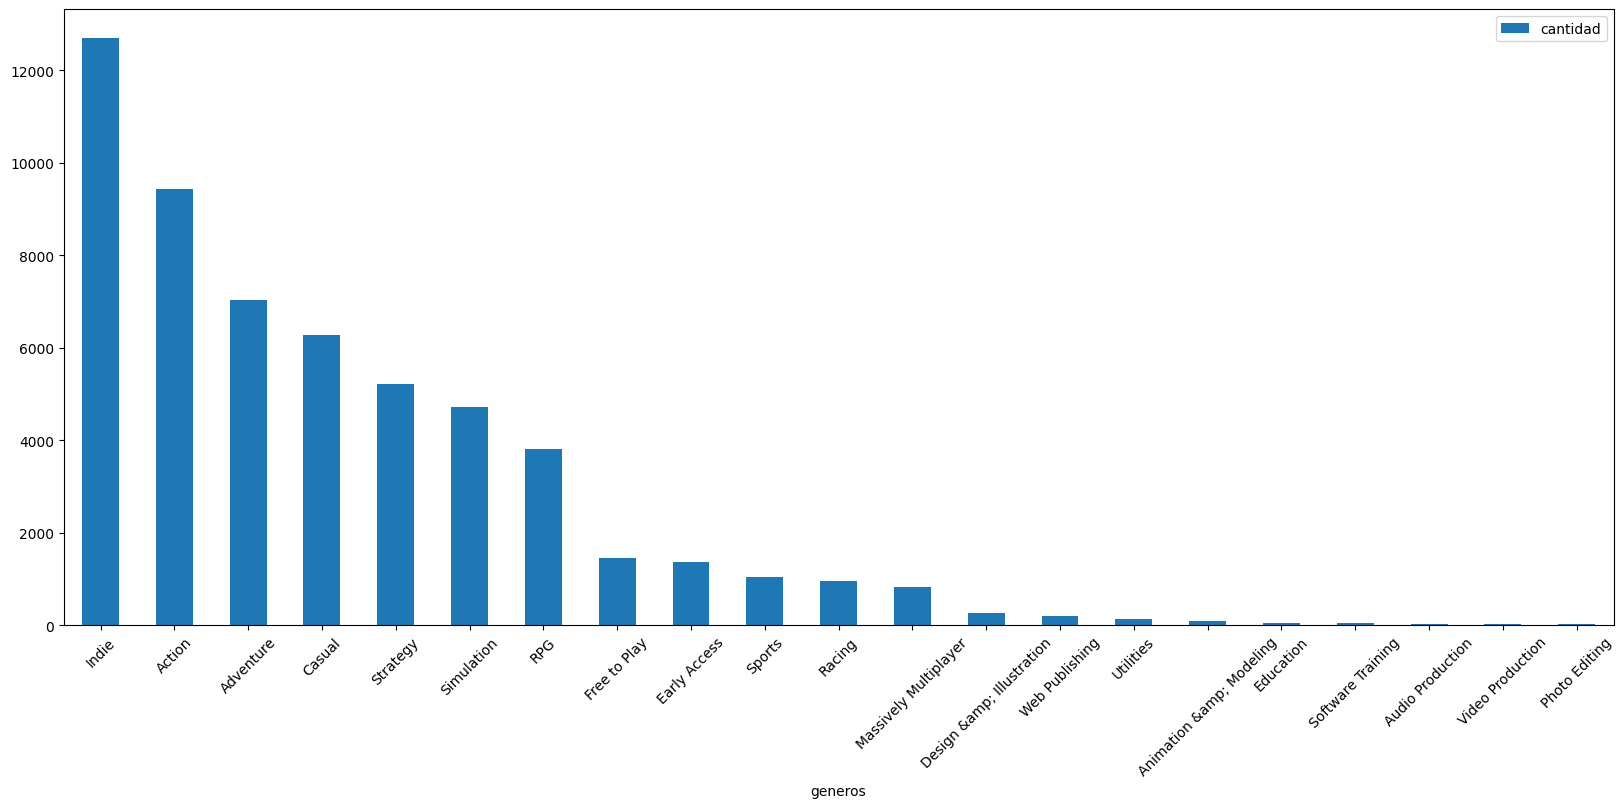

In [52]:
genres.sort_values(by="cantidad",ascending=False).plot(x="generos",y=["cantidad"],kind="bar",figsize=(20, 8),rot=45)

<Axes: xlabel='especificaciones'>

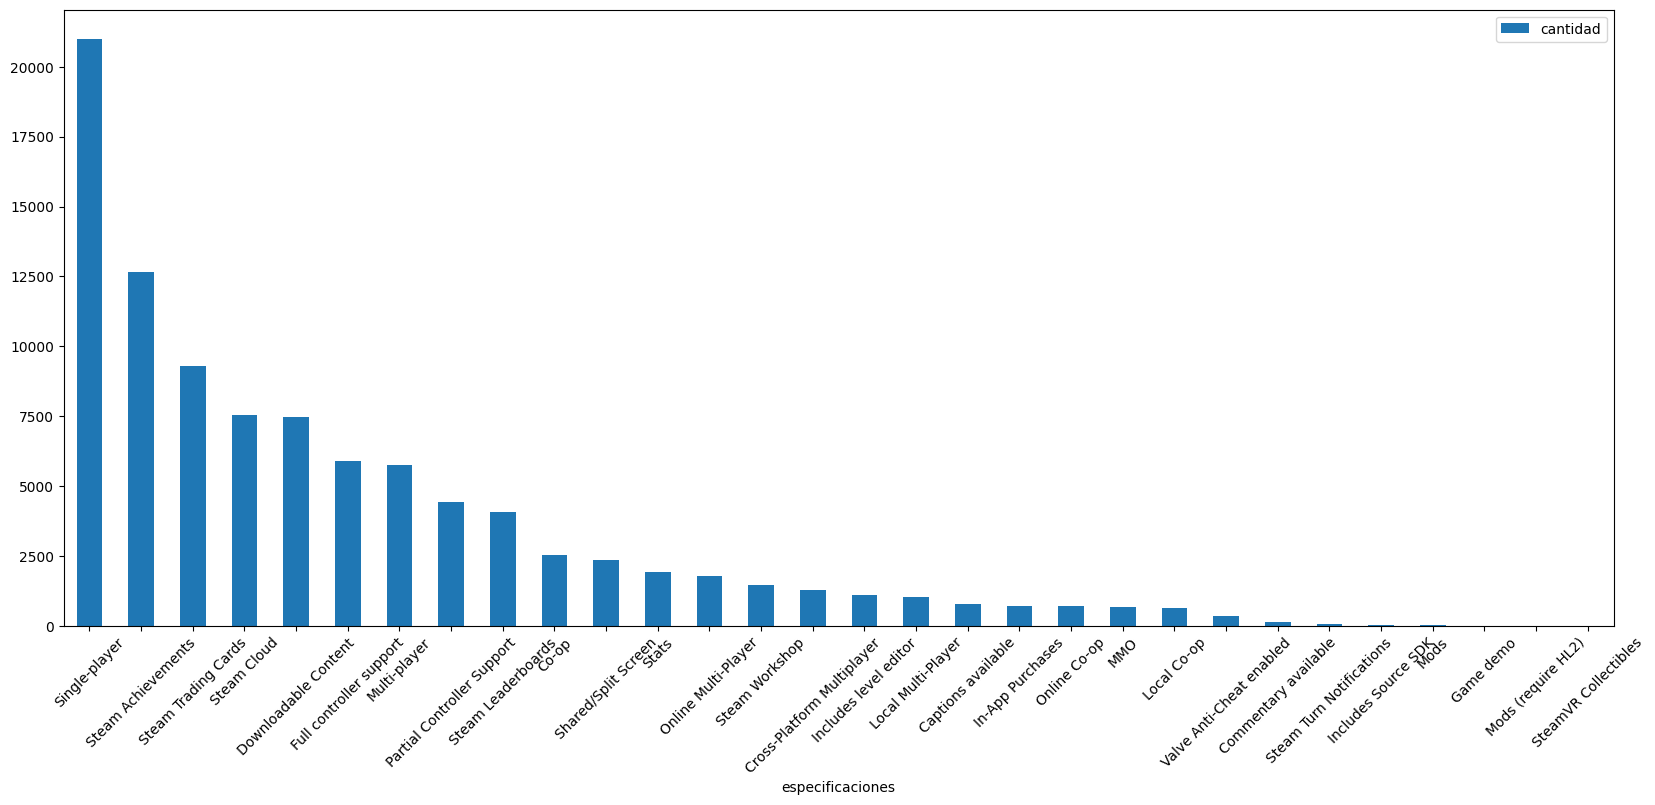

In [53]:
specs.sort_values(by="cantidad",ascending=False).plot(x="especificaciones",y=["cantidad"],kind="bar",figsize=(20, 8),rot=45)

veamos los tipos de datos que quedaron el la tabla

y vemos que claramente el campo price son string pero son numeros con coma

In [54]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22529 entries, 0 to 22529
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   genres        22529 non-null  object
 1   app_name      22529 non-null  object
 2   release_date  22527 non-null  object
 3   tags          22529 non-null  object
 4   specs         22529 non-null  object
 5   price         22529 non-null  object
 6   id            22529 non-null  int64 
 7   developer     22529 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.1+ MB


aqui podemos ver que los valores que no son numero son "Free To Play" o "Free" o "Free to Play"

vamos a filtrar estos valores y luego vemos que nos queda

In [55]:
def is_float(val):
    try:
        float(val)
        return True
    except:
        return False

mask=games["price"].apply(lambda x:not is_float(x))
games[mask]["price"]

1        Free To Play
2        Free to Play
36               Free
158              Free
213              Free
             ...     
22421    Free to Play
22429            Free
22438            Free
22504    Free To Play
22505            Free
Name: price, Length: 1308, dtype: object

In [56]:
gratis=["Free","Free To Play","Free to Play"]
mask=games["price"].apply(lambda x:x in gratis)
games.loc[mask,"price"]=games[mask]["price"].apply(lambda x:0)

estos fueron todos lo valores que quedaron, los demos no son necesariamente gratis, los demos son versiones de prueba que por lo general son gratis con el objetivo de que una cantidad de usuarios lo clasifiquen y la empresa pueda decidir que mejoras hacerle al juego si tiene mucho exito para luego sacar a la venta una version de mejor calidad, pero no siempre estas demos son gratis por lo que vamos a dar los campos nulos, pero los que contengan la palabra Free deja claro es gratis el juego, a esos valores si se les va a inputar un 0

In [57]:
mask=games["price"].apply(lambda x:not is_float(x))
games[mask]["price"]

832                          Free Demo
833                          Free Demo
870                     Play for Free!
882                     Play for Free!
2054                       Install Now
2399     Play WARMACHINE: Tactics Demo
2704                          Free Mod
3234                          Play Now
4320         Free HITMAN™ Holiday Pack
9677                          Free Mod
15419                    Play the Demo
19314                         Free Mod
19315                         Free Mod
21454                        Free Demo
22310                      Third-party
Name: price, dtype: object

In [58]:
def inputar(valor):
    if "Free" in valor:
        return 0
    else:
        return pd.NA
    
games.loc[mask,"price"]=games[mask]["price"].apply(lambda x:inputar(x))

solo quedaron 5 nulos, pero no lo vamos a eliminar ya que, el precio no es un campo que se vaya a utilizar en la api pero si en el modelo asiq ue para que no hayan porblemas con los nulos vamos a asignarle -1

In [59]:
mask=games["price"].apply(lambda x:not is_float(x))
games[mask]["price"]

2054     <NA>
2399     <NA>
3234     <NA>
15419    <NA>
22310    <NA>
Name: price, dtype: object

tambien aprovechamos de convertir el formato a float

In [60]:
games["price"].fillna(-1,inplace=True)
games["price"]=games["price"].apply(lambda x:float(x))

luego vamos hacer rapidamente un analisis a los distintos precios que pueden tener un juego, y el promedio de estos por categoria

In [61]:
def armar_tabla_promedios(campo,campo_nuevo):
    unicos=[]
    mask=games["price"]!=-1

    for i in games[mask].index:
        for n in games.at[i,campo]:
            if n not in unicos:
                unicos.append(n)

    dicc={}
    for n in unicos:
        mask1=mask & (games[campo].apply(lambda x:n in x))
        dicc[n]=games[mask1]["price"].mean()

    tab={campo_nuevo:[],"promedio":[]}
    tab[campo_nuevo]=unicos

    for n in unicos:
        tab["promedio"].append(dicc[n])

    tab=pd.DataFrame(tab)
    tab[campo_nuevo]=tab[campo_nuevo].apply(lambda x: x.replace("&amp;","&"))
    return tab

tab_generos=armar_tabla_promedios("genres","generos")
tab_specs=armar_tabla_promedios("specs","especificaciones")

bueno aqui graficamos el promedio de los precios de los juego por genero

<Axes: xlabel='generos'>

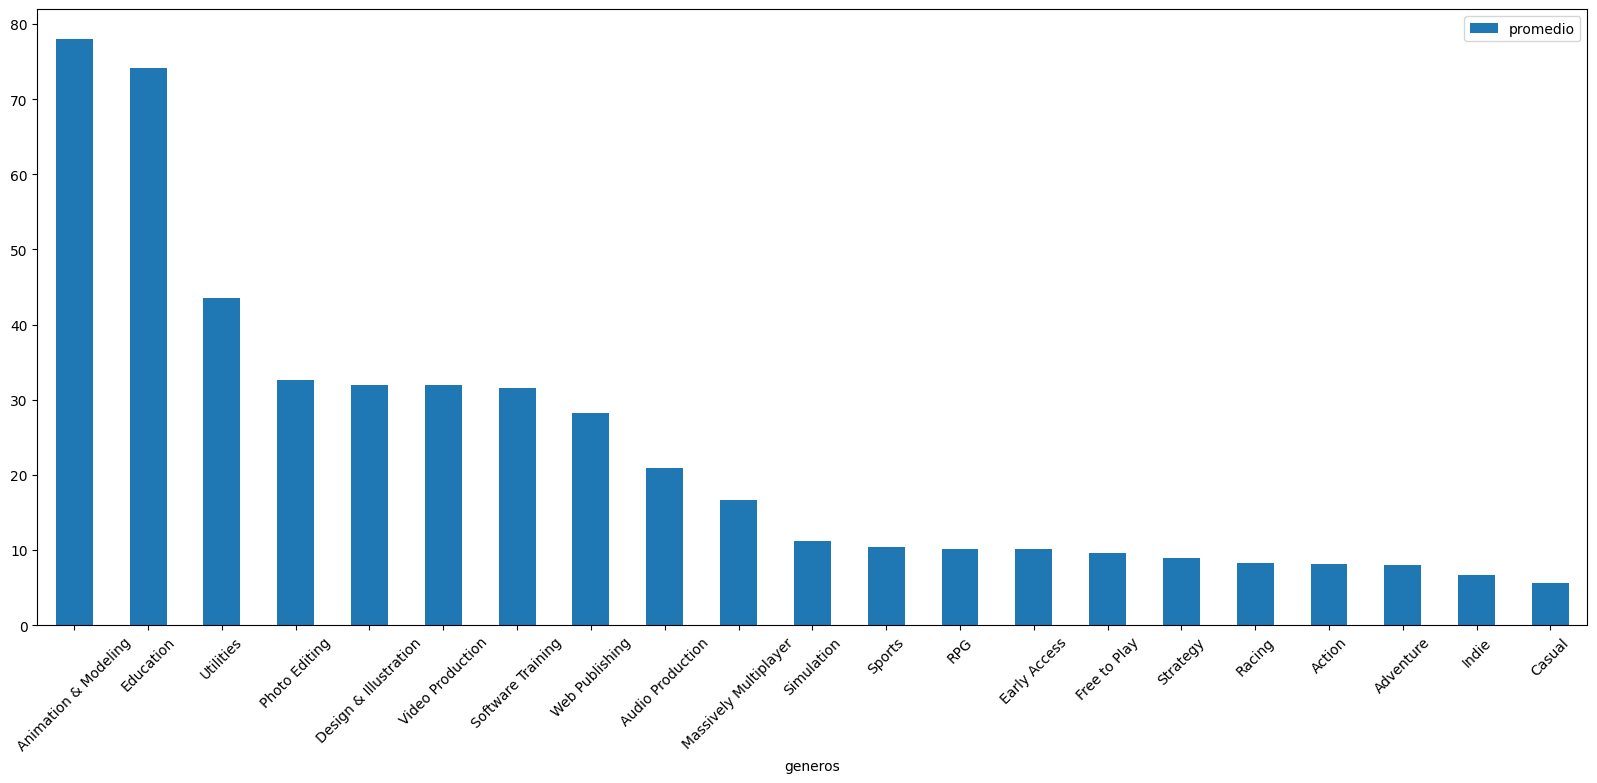

In [62]:
tab_generos.sort_values(by="promedio",ascending=False).plot(x="generos",y=["promedio"],kind="bar",figsize=(20, 8),rot=45)

<Axes: xlabel='especificaciones'>

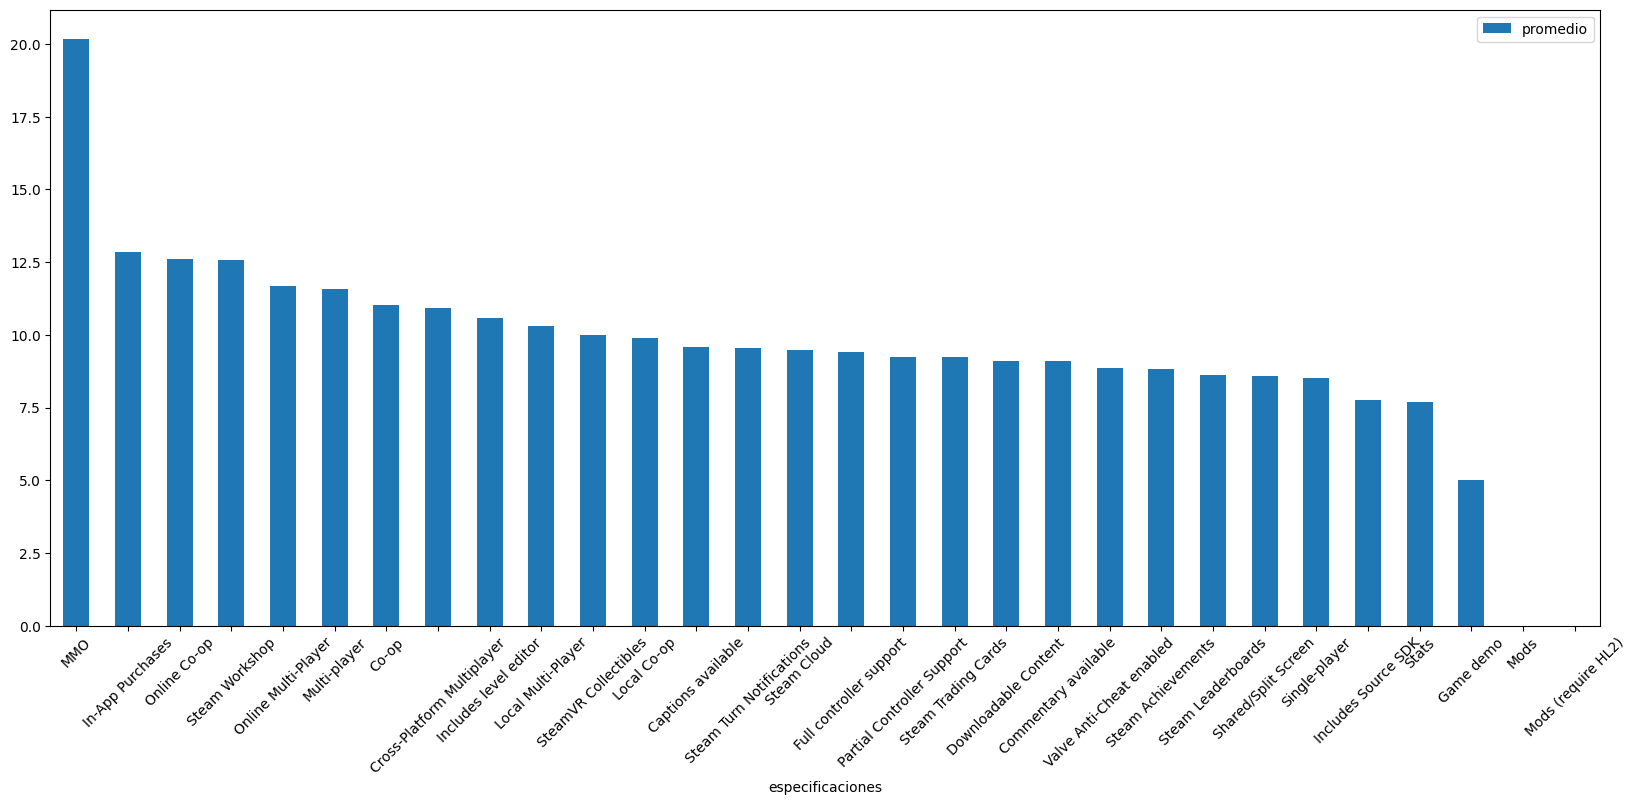

In [63]:
tab_specs.sort_values(by="promedio",ascending=False).plot(x="especificaciones",y=["promedio"],kind="bar",figsize=(20, 8),rot=45)

hechando un vistazo a los outliers del campo price, son bastantes, vamos a analizarlos

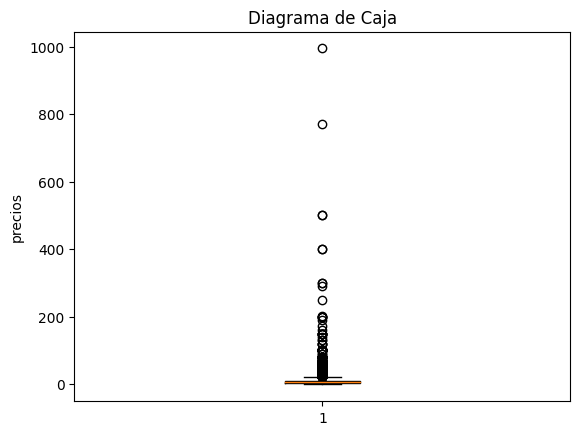

In [64]:
plt.boxplot(games["price"])

# Añadir etiquetas y título
plt.xlabel("")  #nombre de campo
plt.ylabel("precios")  #valores
plt.title('Diagrama de Caja')

# Mostrar el gráfico
plt.show()


bueno es bastante comprensible que 20 sea un outlier considerando que la mayoria de los valores son precios muy bajos.

In [65]:
Q1 = games["price"].quantile(0.25)
Q3 = games["price"].quantile(0.75)
IQR = Q3 - Q1

# Definir límites para identificar outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Identificar outliers
outliers = games[(games["price"] < limite_inferior) | (games["price"] > limite_superior)]

#pd.set_option('display.max_rows', None)

# Imprimir los outliers
print("Número de outliers:", len(outliers))
print("maximo outlier: "+str(outliers["price"].max()))
print("minimo outlier: "+str(outliers["price"].min()))

#pd.reset_option('display.max_rows')

Número de outliers: 1361
maximo outlier: 995.0
minimo outlier: 20.99


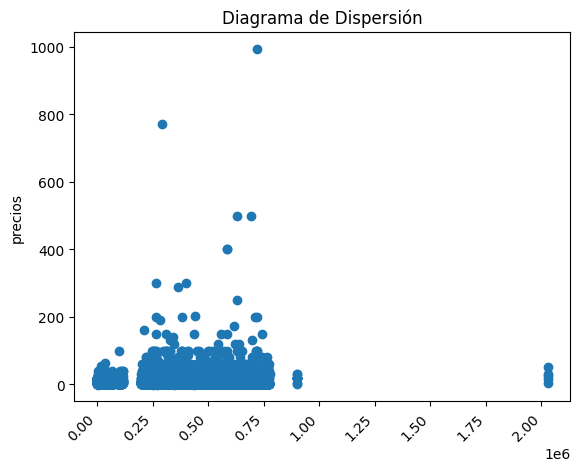

In [66]:
plt.scatter(games["id"],games["price"])

plt.xticks(rotation=45, ha='right')

# Añadir etiquetas y título
plt.ylabel('precios')
plt.title('Diagrama de Dispersión')

# Mostrar el diagrama
plt.show()

estos son los precios mas altos, y los precios se hacen muy raros cuando llegan a 400, y hacen mucho ruido los que cuestan 995 y 771, aunque pueda parecer falso he investigado que han existido juegos que tienen ese precio, y que puede llegar a tenerlo, pero no es comun que se encuentren juegos.

In [67]:
mask=outliers["price"]>200
outliers[mask]["price"].sort_values(ascending=False)

8452     995.00
2046     771.71
9917     499.99
12290    499.99
6447     399.99
6448     399.99
3523     299.99
20292    299.99
18291    289.99
12289    249.99
10670    202.76
Name: price, dtype: float64

dando por finalizado el EDA guardamos los archivos con exactamente el mismo nombre, y empezar a continuacion con con las funciones de la api

In [68]:
porcentaje=0.85

indices_items=random.sample(list(items.index),int(len(items)*porcentaje))
indices_items.sort()
indices_reviews=random.sample(list(reviews.index),int(len(reviews)*porcentaje))
indices_reviews.sort()
indices_games=random.sample(list(games.index),int(len(games)*porcentaje))
indices_games.sort()

'porcentaje=0.85\n\nindices_items=random.sample(list(items.index),int(len(items)*porcentaje))\nindices_items.sort()\nindices_reviews=random.sample(list(reviews.index),int(len(reviews)*porcentaje))\nindices_reviews.sort()\nindices_games=random.sample(list(games.index),int(len(games)*porcentaje))\nindices_games.sort()'

In [69]:
items.drop(index=indices_items,inplace=True)
reviews.drop(index=indices_reviews,inplace=True)
games.drop(index=indices_games,inplace=True)

'items.drop(index=indices_items,inplace=True)\nreviews.drop(index=indices_reviews,inplace=True)\ngames.drop(index=indices_games,inplace=True)'

In [70]:
items.to_parquet("deploy/datasets/users_items.parquet")
reviews.to_csv("deploy/datasets/user_reviews.csv",sep=";")
games.to_csv("deploy/datasets/steam_games.csv",sep=";")

'items.to_parquet("deploy/datasets/users_items.parquet")\nreviews.to_csv("deploy/datasets/user_reviews.csv",sep=";")\ngames.to_csv("deploy/datasets/steam_games.csv",sep=";")'